In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:37 - loss: 1.6478 - STD: 0.0802 - MAE: 0.1942

 5/78 [>.............................] - ETA: 1s - loss: 1.4250 - STD: 0.1793 - MAE: 0.1519  

 9/78 [==>...........................] - ETA: 1s - loss: 1.3839 - STD: 0.1851 - MAE: 0.1490

13/78 [====>.........................] - ETA: 1s - loss: 1.3673 - STD: 0.1868 - MAE: 0.1480

16/78 [=====>........................] - ETA: 0s - loss: 1.3595 - STD: 0.1902 - MAE: 0.1466

20/78 [======>.......................] - ETA: 0s - loss: 1.3529 - STD: 0.1905 - MAE: 0.1463

24/78 [========>.....................] - ETA: 0s - loss: 1.3487 - STD: 0.1897 - MAE: 0.1466

28/78 [=========>....................] - ETA: 0s - loss: 1.3444 - STD: 0.1907 - MAE: 0.1461

32/78 [===========>..................] - ETA: 0s - loss: 1.3404 - STD: 0.1914 - MAE: 0.1458

36/78 [============>.................] - ETA: 0s - loss: 1.3377 - STD: 0.1908 - MAE: 0.1460

40/78 [==============>...............] - ETA: 0s - loss: 1.3350 - STD: 0.1907 - MAE: 0.1459

42/78 [===============>..............] - ETA: 1s - loss: 1.3337 - STD: 0.1908 - MAE: 0.1458

46/78 [================>.............] - ETA: 0s - loss: 1.3304 - STD: 0.1907 - MAE: 0.1457

50/78 [==================>...........] - ETA: 0s - loss: 1.3269 - STD: 0.1907 - MAE: 0.1456

54/78 [===================>..........] - ETA: 0s - loss: 1.3225 - STD: 0.1910 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3185 - STD: 0.1913 - MAE: 0.1451

62/78 [======================>.......] - ETA: 0s - loss: 1.3137 - STD: 0.1916 - MAE: 0.1448

66/78 [========================>.....] - ETA: 0s - loss: 1.3094 - STD: 0.1920 - MAE: 0.1445

70/78 [=========================>....] - ETA: 0s - loss: 1.3039 - STD: 0.1925 - MAE: 0.1441

74/78 [===========================>..] - ETA: 0s - loss: 1.2989 - STD: 0.1928 - MAE: 0.1439

78/78 [==============================] - ETA: 0s - loss: 1.2939 - STD: 0.1931 - MAE: 0.1436

78/78 [==============================] - 4s 32ms/step - loss: 1.2939 - STD: 0.1931 - MAE: 0.1436 - val_loss: 1.1539 - val_STD: 0.2031 - val_MAE: 0.1360


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1909 - STD: 0.2017 - MAE: 0.1372

 5/78 [>.............................] - ETA: 1s - loss: 1.1879 - STD: 0.2000 - MAE: 0.1378

 9/78 [==>...........................] - ETA: 1s - loss: 1.1810 - STD: 0.1997 - MAE: 0.1377

13/78 [====>.........................] - ETA: 1s - loss: 1.1774 - STD: 0.1995 - MAE: 0.1377

17/78 [=====>........................] - ETA: 0s - loss: 1.1710 - STD: 0.1997 - MAE: 0.1374

21/78 [=======>......................] - ETA: 0s - loss: 1.1643 - STD: 0.2000 - MAE: 0.1371

25/78 [========>.....................] - ETA: 0s - loss: 1.1568 - STD: 0.2006 - MAE: 0.1366

29/78 [==========>...................] - ETA: 0s - loss: 1.1499 - STD: 0.2008 - MAE: 0.1363

33/78 [===========>..................] - ETA: 0s - loss: 1.1428 - STD: 0.2012 - MAE: 0.1359

37/78 [=============>................] - ETA: 0s - loss: 1.1346 - STD: 0.2019 - MAE: 0.1353

41/78 [==============>...............] - ETA: 0s - loss: 1.1278 - STD: 0.2026 - MAE: 0.1347

45/78 [================>.............] - ETA: 0s - loss: 1.1207 - STD: 0.2033 - MAE: 0.1342

49/78 [=================>............] - ETA: 0s - loss: 1.1148 - STD: 0.2039 - MAE: 0.1337

54/78 [===================>..........] - ETA: 0s - loss: 1.1089 - STD: 0.2046 - MAE: 0.1332

58/78 [=====================>........] - ETA: 0s - loss: 1.1033 - STD: 0.2052 - MAE: 0.1327

62/78 [======================>.......] - ETA: 0s - loss: 1.0977 - STD: 0.2058 - MAE: 0.1322

66/78 [========================>.....] - ETA: 0s - loss: 1.0930 - STD: 0.2064 - MAE: 0.1318

70/78 [=========================>....] - ETA: 0s - loss: 1.0884 - STD: 0.2070 - MAE: 0.1314

74/78 [===========================>..] - ETA: 0s - loss: 1.0842 - STD: 0.2074 - MAE: 0.1311

78/78 [==============================] - ETA: 0s - loss: 1.0803 - STD: 0.2078 - MAE: 0.1307

78/78 [==============================] - 1s 18ms/step - loss: 1.0803 - STD: 0.2078 - MAE: 0.1307 - val_loss: 0.9855 - val_STD: 0.2043 - val_MAE: 0.1287


Epoch 3/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9936 - STD: 0.2059 - MAE: 0.1281

 4/78 [>.............................] - ETA: 1s - loss: 0.9936 - STD: 0.2166 - MAE: 0.1235

 8/78 [==>...........................] - ETA: 1s - loss: 0.9921 - STD: 0.2158 - MAE: 0.1239

12/78 [===>..........................] - ETA: 1s - loss: 0.9878 - STD: 0.2158 - MAE: 0.1237

16/78 [=====>........................] - ETA: 0s - loss: 0.9845 - STD: 0.2156 - MAE: 0.1236

20/78 [======>.......................] - ETA: 0s - loss: 0.9824 - STD: 0.2161 - MAE: 0.1233

24/78 [========>.....................] - ETA: 0s - loss: 0.9795 - STD: 0.2167 - MAE: 0.1230

28/78 [=========>....................] - ETA: 0s - loss: 0.9753 - STD: 0.2173 - MAE: 0.1225

32/78 [===========>..................] - ETA: 0s - loss: 0.9713 - STD: 0.2176 - MAE: 0.1222

36/78 [============>.................] - ETA: 0s - loss: 0.9663 - STD: 0.2181 - MAE: 0.1217

40/78 [==============>...............] - ETA: 0s - loss: 0.9631 - STD: 0.2186 - MAE: 0.1214

44/78 [===============>..............] - ETA: 0s - loss: 0.9601 - STD: 0.2189 - MAE: 0.1211

48/78 [=================>............] - ETA: 0s - loss: 0.9570 - STD: 0.2194 - MAE: 0.1208

52/78 [===================>..........] - ETA: 0s - loss: 0.9539 - STD: 0.2197 - MAE: 0.1205

56/78 [====================>.........] - ETA: 0s - loss: 0.9510 - STD: 0.2199 - MAE: 0.1203

60/78 [======================>.......] - ETA: 0s - loss: 0.9496 - STD: 0.2202 - MAE: 0.1201

64/78 [=======================>......] - ETA: 0s - loss: 0.9473 - STD: 0.2205 - MAE: 0.1199

68/78 [=========================>....] - ETA: 0s - loss: 0.9445 - STD: 0.2208 - MAE: 0.1197

72/78 [==========================>...] - ETA: 0s - loss: 0.9418 - STD: 0.2211 - MAE: 0.1194

76/78 [============================>.] - ETA: 0s - loss: 0.9396 - STD: 0.2213 - MAE: 0.1193

78/78 [==============================] - 1s 18ms/step - loss: 0.9386 - STD: 0.2214 - MAE: 0.1191 - val_loss: 0.9046 - val_STD: 0.2245 - val_MAE: 0.1161


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8912 - STD: 0.2278 - MAE: 0.1141

 4/78 [>.............................] - ETA: 1s - loss: 0.8920 - STD: 0.2258 - MAE: 0.1152

 8/78 [==>...........................] - ETA: 1s - loss: 0.8911 - STD: 0.2261 - MAE: 0.1150

12/78 [===>..........................] - ETA: 1s - loss: 0.8914 - STD: 0.2269 - MAE: 0.1146

16/78 [=====>........................] - ETA: 0s - loss: 0.8912 - STD: 0.2267 - MAE: 0.1147

20/78 [======>.......................] - ETA: 0s - loss: 0.8906 - STD: 0.2267 - MAE: 0.1147

24/78 [========>.....................] - ETA: 0s - loss: 0.8904 - STD: 0.2269 - MAE: 0.1146

28/78 [=========>....................] - ETA: 0s - loss: 0.8888 - STD: 0.2271 - MAE: 0.1144

32/78 [===========>..................] - ETA: 0s - loss: 0.8876 - STD: 0.2271 - MAE: 0.1144

36/78 [============>.................] - ETA: 0s - loss: 0.8861 - STD: 0.2274 - MAE: 0.1142

40/78 [==============>...............] - ETA: 0s - loss: 0.8863 - STD: 0.2275 - MAE: 0.1141

44/78 [===============>..............] - ETA: 0s - loss: 0.8852 - STD: 0.2277 - MAE: 0.1140

48/78 [=================>............] - ETA: 0s - loss: 0.8844 - STD: 0.2276 - MAE: 0.1140

52/78 [===================>..........] - ETA: 0s - loss: 0.8840 - STD: 0.2279 - MAE: 0.1138

56/78 [====================>.........] - ETA: 0s - loss: 0.8831 - STD: 0.2280 - MAE: 0.1138

60/78 [======================>.......] - ETA: 0s - loss: 0.8831 - STD: 0.2280 - MAE: 0.1138

63/78 [=======================>......] - ETA: 0s - loss: 0.8827 - STD: 0.2281 - MAE: 0.1137

67/78 [========================>.....] - ETA: 0s - loss: 0.8819 - STD: 0.2282 - MAE: 0.1137

71/78 [==========================>...] - ETA: 0s - loss: 0.8812 - STD: 0.2282 - MAE: 0.1136

74/78 [===========================>..] - ETA: 0s - loss: 0.8807 - STD: 0.2283 - MAE: 0.1135

78/78 [==============================] - ETA: 0s - loss: 0.8806 - STD: 0.2283 - MAE: 0.1135

78/78 [==============================] - 1s 18ms/step - loss: 0.8806 - STD: 0.2283 - MAE: 0.1135 - val_loss: 0.8667 - val_STD: 0.2256 - val_MAE: 0.1139


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8619 - STD: 0.2288 - MAE: 0.1122

 5/78 [>.............................] - ETA: 1s - loss: 0.8667 - STD: 0.2306 - MAE: 0.1117

 9/78 [==>...........................] - ETA: 1s - loss: 0.8658 - STD: 0.2294 - MAE: 0.1123

13/78 [====>.........................] - ETA: 1s - loss: 0.8646 - STD: 0.2301 - MAE: 0.1119

17/78 [=====>........................] - ETA: 0s - loss: 0.8628 - STD: 0.2305 - MAE: 0.1117

21/78 [=======>......................] - ETA: 0s - loss: 0.8632 - STD: 0.2301 - MAE: 0.1119

25/78 [========>.....................] - ETA: 0s - loss: 0.8612 - STD: 0.2306 - MAE: 0.1116

29/78 [==========>...................] - ETA: 0s - loss: 0.8602 - STD: 0.2309 - MAE: 0.1114

33/78 [===========>..................] - ETA: 0s - loss: 0.8607 - STD: 0.2306 - MAE: 0.1116

37/78 [=============>................] - ETA: 0s - loss: 0.8606 - STD: 0.2307 - MAE: 0.1115

41/78 [==============>...............] - ETA: 0s - loss: 0.8600 - STD: 0.2308 - MAE: 0.1114

45/78 [================>.............] - ETA: 0s - loss: 0.8594 - STD: 0.2308 - MAE: 0.1114

49/78 [=================>............] - ETA: 0s - loss: 0.8588 - STD: 0.2308 - MAE: 0.1114

53/78 [===================>..........] - ETA: 0s - loss: 0.8587 - STD: 0.2308 - MAE: 0.1114

57/78 [====================>.........] - ETA: 0s - loss: 0.8582 - STD: 0.2309 - MAE: 0.1113

61/78 [======================>.......] - ETA: 0s - loss: 0.8575 - STD: 0.2309 - MAE: 0.1113

65/78 [========================>.....] - ETA: 0s - loss: 0.8569 - STD: 0.2312 - MAE: 0.1111

68/78 [=========================>....] - ETA: 0s - loss: 0.8567 - STD: 0.2312 - MAE: 0.1111

72/78 [==========================>...] - ETA: 0s - loss: 0.8563 - STD: 0.2312 - MAE: 0.1111

76/78 [============================>.] - ETA: 0s - loss: 0.8560 - STD: 0.2313 - MAE: 0.1110

78/78 [==============================] - 1s 18ms/step - loss: 0.8558 - STD: 0.2312 - MAE: 0.1110 - val_loss: 0.8413 - val_STD: 0.2295 - val_MAE: 0.1108


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8539 - STD: 0.2340 - MAE: 0.1097

 4/78 [>.............................] - ETA: 1s - loss: 0.8489 - STD: 0.2324 - MAE: 0.1101

 8/78 [==>...........................] - ETA: 1s - loss: 0.8431 - STD: 0.2320 - MAE: 0.1100

12/78 [===>..........................] - ETA: 1s - loss: 0.8420 - STD: 0.2324 - MAE: 0.1098

16/78 [=====>........................] - ETA: 0s - loss: 0.8420 - STD: 0.2324 - MAE: 0.1098

20/78 [======>.......................] - ETA: 0s - loss: 0.8420 - STD: 0.2328 - MAE: 0.1096

24/78 [========>.....................] - ETA: 0s - loss: 0.8422 - STD: 0.2329 - MAE: 0.1096

28/78 [=========>....................] - ETA: 0s - loss: 0.8416 - STD: 0.2329 - MAE: 0.1096

32/78 [===========>..................] - ETA: 0s - loss: 0.8417 - STD: 0.2331 - MAE: 0.1095

36/78 [============>.................] - ETA: 0s - loss: 0.8410 - STD: 0.2331 - MAE: 0.1094

40/78 [==============>...............] - ETA: 0s - loss: 0.8406 - STD: 0.2329 - MAE: 0.1095

44/78 [===============>..............] - ETA: 0s - loss: 0.8418 - STD: 0.2330 - MAE: 0.1096

48/78 [=================>............] - ETA: 0s - loss: 0.8417 - STD: 0.2330 - MAE: 0.1096

52/78 [===================>..........] - ETA: 0s - loss: 0.8419 - STD: 0.2331 - MAE: 0.1095

56/78 [====================>.........] - ETA: 0s - loss: 0.8416 - STD: 0.2331 - MAE: 0.1095

60/78 [======================>.......] - ETA: 0s - loss: 0.8410 - STD: 0.2331 - MAE: 0.1095

64/78 [=======================>......] - ETA: 0s - loss: 0.8410 - STD: 0.2331 - MAE: 0.1095

68/78 [=========================>....] - ETA: 0s - loss: 0.8404 - STD: 0.2332 - MAE: 0.1095

72/78 [==========================>...] - ETA: 0s - loss: 0.8391 - STD: 0.2333 - MAE: 0.1093

76/78 [============================>.] - ETA: 0s - loss: 0.8383 - STD: 0.2333 - MAE: 0.1093

78/78 [==============================] - 1s 18ms/step - loss: 0.8381 - STD: 0.2334 - MAE: 0.1092 - val_loss: 0.8284 - val_STD: 0.2260 - val_MAE: 0.1121


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8329 - STD: 0.2302 - MAE: 0.1105

 4/78 [>.............................] - ETA: 1s - loss: 0.8301 - STD: 0.2330 - MAE: 0.1091

 8/78 [==>...........................] - ETA: 1s - loss: 0.8330 - STD: 0.2334 - MAE: 0.1090

12/78 [===>..........................] - ETA: 1s - loss: 0.8281 - STD: 0.2340 - MAE: 0.1084

16/78 [=====>........................] - ETA: 0s - loss: 0.8271 - STD: 0.2339 - MAE: 0.1085

20/78 [======>.......................] - ETA: 0s - loss: 0.8258 - STD: 0.2345 - MAE: 0.1081

24/78 [========>.....................] - ETA: 0s - loss: 0.8261 - STD: 0.2344 - MAE: 0.1082

28/78 [=========>....................] - ETA: 0s - loss: 0.8256 - STD: 0.2348 - MAE: 0.1080

32/78 [===========>..................] - ETA: 0s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1079

36/78 [============>.................] - ETA: 0s - loss: 0.8242 - STD: 0.2347 - MAE: 0.1080

40/78 [==============>...............] - ETA: 0s - loss: 0.8236 - STD: 0.2347 - MAE: 0.1079

44/78 [===============>..............] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1080

48/78 [=================>............] - ETA: 0s - loss: 0.8225 - STD: 0.2348 - MAE: 0.1079

52/78 [===================>..........] - ETA: 0s - loss: 0.8215 - STD: 0.2349 - MAE: 0.1078

56/78 [====================>.........] - ETA: 0s - loss: 0.8212 - STD: 0.2350 - MAE: 0.1077

60/78 [======================>.......] - ETA: 0s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1076

64/78 [=======================>......] - ETA: 0s - loss: 0.8206 - STD: 0.2351 - MAE: 0.1076

68/78 [=========================>....] - ETA: 0s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1075

72/78 [==========================>...] - ETA: 0s - loss: 0.8200 - STD: 0.2351 - MAE: 0.1076

76/78 [============================>.] - ETA: 0s - loss: 0.8190 - STD: 0.2352 - MAE: 0.1075

78/78 [==============================] - 1s 18ms/step - loss: 0.8185 - STD: 0.2353 - MAE: 0.1074 - val_loss: 0.8086 - val_STD: 0.2344 - val_MAE: 0.1075


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7990 - STD: 0.2381 - MAE: 0.1047

 4/78 [>.............................] - ETA: 1s - loss: 0.8045 - STD: 0.2363 - MAE: 0.1061

 8/78 [==>...........................] - ETA: 1s - loss: 0.8029 - STD: 0.2365 - MAE: 0.1061

12/78 [===>..........................] - ETA: 1s - loss: 0.8013 - STD: 0.2372 - MAE: 0.1056

15/78 [====>.........................] - ETA: 1s - loss: 0.8030 - STD: 0.2367 - MAE: 0.1059

19/78 [======>.......................] - ETA: 0s - loss: 0.8041 - STD: 0.2367 - MAE: 0.1061

23/78 [=======>......................] - ETA: 0s - loss: 0.8064 - STD: 0.2370 - MAE: 0.1061

27/78 [=========>....................] - ETA: 0s - loss: 0.8071 - STD: 0.2367 - MAE: 0.1062

31/78 [==========>...................] - ETA: 0s - loss: 0.8056 - STD: 0.2369 - MAE: 0.1060

35/78 [============>.................] - ETA: 0s - loss: 0.8052 - STD: 0.2367 - MAE: 0.1061

39/78 [==============>...............] - ETA: 0s - loss: 0.8050 - STD: 0.2368 - MAE: 0.1061

43/78 [===============>..............] - ETA: 0s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1061

47/78 [=================>............] - ETA: 0s - loss: 0.8046 - STD: 0.2370 - MAE: 0.1060

51/78 [==================>...........] - ETA: 0s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1060

55/78 [====================>.........] - ETA: 0s - loss: 0.8039 - STD: 0.2369 - MAE: 0.1060

60/78 [======================>.......] - ETA: 0s - loss: 0.8035 - STD: 0.2369 - MAE: 0.1060

64/78 [=======================>......] - ETA: 0s - loss: 0.8038 - STD: 0.2369 - MAE: 0.1060

68/78 [=========================>....] - ETA: 0s - loss: 0.8041 - STD: 0.2368 - MAE: 0.1061

72/78 [==========================>...] - ETA: 0s - loss: 0.8043 - STD: 0.2369 - MAE: 0.1061

76/78 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1061

78/78 [==============================] - 1s 18ms/step - loss: 0.8047 - STD: 0.2369 - MAE: 0.1061 - val_loss: 0.8117 - val_STD: 0.2273 - val_MAE: 0.1110


Epoch 9/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7923 - STD: 0.2317 - MAE: 0.1082

 5/78 [>.............................] - ETA: 1s - loss: 0.8016 - STD: 0.2357 - MAE: 0.1065

 9/78 [==>...........................] - ETA: 1s - loss: 0.8015 - STD: 0.2361 - MAE: 0.1063

13/78 [====>.........................] - ETA: 0s - loss: 0.7991 - STD: 0.2368 - MAE: 0.1059

17/78 [=====>........................] - ETA: 0s - loss: 0.7961 - STD: 0.2372 - MAE: 0.1056

21/78 [=======>......................] - ETA: 0s - loss: 0.7944 - STD: 0.2368 - MAE: 0.1056

25/78 [========>.....................] - ETA: 0s - loss: 0.7958 - STD: 0.2370 - MAE: 0.1056

29/78 [==========>...................] - ETA: 0s - loss: 0.7973 - STD: 0.2371 - MAE: 0.1057

33/78 [===========>..................] - ETA: 0s - loss: 0.7968 - STD: 0.2373 - MAE: 0.1056

37/78 [=============>................] - ETA: 0s - loss: 0.7956 - STD: 0.2373 - MAE: 0.1055

41/78 [==============>...............] - ETA: 0s - loss: 0.7946 - STD: 0.2375 - MAE: 0.1054

45/78 [================>.............] - ETA: 0s - loss: 0.7939 - STD: 0.2375 - MAE: 0.1053

49/78 [=================>............] - ETA: 0s - loss: 0.7935 - STD: 0.2375 - MAE: 0.1053

53/78 [===================>..........] - ETA: 0s - loss: 0.7934 - STD: 0.2375 - MAE: 0.1053

57/78 [====================>.........] - ETA: 0s - loss: 0.7931 - STD: 0.2376 - MAE: 0.1052

61/78 [======================>.......] - ETA: 0s - loss: 0.7920 - STD: 0.2377 - MAE: 0.1051

65/78 [========================>.....] - ETA: 0s - loss: 0.7918 - STD: 0.2377 - MAE: 0.1051

69/78 [=========================>....] - ETA: 0s - loss: 0.7918 - STD: 0.2378 - MAE: 0.1050

73/78 [===========================>..] - ETA: 0s - loss: 0.7915 - STD: 0.2380 - MAE: 0.1050

77/78 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2380 - MAE: 0.1049

78/78 [==============================] - 1s 18ms/step - loss: 0.7917 - STD: 0.2380 - MAE: 0.1049 - val_loss: 0.8332 - val_STD: 0.2366 - val_MAE: 0.1077


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7916 - STD: 0.2403 - MAE: 0.1037

 5/78 [>.............................] - ETA: 1s - loss: 0.7868 - STD: 0.2398 - MAE: 0.1039

 9/78 [==>...........................] - ETA: 1s - loss: 0.7900 - STD: 0.2388 - MAE: 0.1045

13/78 [====>.........................] - ETA: 1s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1050

17/78 [=====>........................] - ETA: 0s - loss: 0.7878 - STD: 0.2383 - MAE: 0.1048

21/78 [=======>......................] - ETA: 0s - loss: 0.7862 - STD: 0.2382 - MAE: 0.1047

25/78 [========>.....................] - ETA: 0s - loss: 0.7849 - STD: 0.2382 - MAE: 0.1047

29/78 [==========>...................] - ETA: 0s - loss: 0.7845 - STD: 0.2383 - MAE: 0.1045

33/78 [===========>..................] - ETA: 0s - loss: 0.7866 - STD: 0.2385 - MAE: 0.1045

36/78 [============>.................] - ETA: 0s - loss: 0.7863 - STD: 0.2386 - MAE: 0.1045

40/78 [==============>...............] - ETA: 0s - loss: 0.7865 - STD: 0.2387 - MAE: 0.1045

44/78 [===============>..............] - ETA: 0s - loss: 0.7861 - STD: 0.2387 - MAE: 0.1044

48/78 [=================>............] - ETA: 0s - loss: 0.7858 - STD: 0.2387 - MAE: 0.1044

51/78 [==================>...........] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1043

55/78 [====================>.........] - ETA: 0s - loss: 0.7856 - STD: 0.2386 - MAE: 0.1044

59/78 [=====================>........] - ETA: 0s - loss: 0.7849 - STD: 0.2386 - MAE: 0.1044

63/78 [=======================>......] - ETA: 0s - loss: 0.7849 - STD: 0.2387 - MAE: 0.1044

66/78 [========================>.....] - ETA: 0s - loss: 0.7843 - STD: 0.2387 - MAE: 0.1043

70/78 [=========================>....] - ETA: 0s - loss: 0.7842 - STD: 0.2389 - MAE: 0.1042

74/78 [===========================>..] - ETA: 0s - loss: 0.7840 - STD: 0.2389 - MAE: 0.1042

78/78 [==============================] - ETA: 0s - loss: 0.7833 - STD: 0.2390 - MAE: 0.1041

78/78 [==============================] - 1s 18ms/step - loss: 0.7833 - STD: 0.2390 - MAE: 0.1041 - val_loss: 0.7946 - val_STD: 0.2320 - val_MAE: 0.1086


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7856 - STD: 0.2354 - MAE: 0.1058

 5/78 [>.............................] - ETA: 1s - loss: 0.7848 - STD: 0.2374 - MAE: 0.1051

 9/78 [==>...........................] - ETA: 1s - loss: 0.7844 - STD: 0.2384 - MAE: 0.1047

13/78 [====>.........................] - ETA: 1s - loss: 0.7827 - STD: 0.2387 - MAE: 0.1043

17/78 [=====>........................] - ETA: 0s - loss: 0.7787 - STD: 0.2390 - MAE: 0.1039

21/78 [=======>......................] - ETA: 0s - loss: 0.7773 - STD: 0.2390 - MAE: 0.1039

25/78 [========>.....................] - ETA: 0s - loss: 0.7755 - STD: 0.2393 - MAE: 0.1036

29/78 [==========>...................] - ETA: 0s - loss: 0.7751 - STD: 0.2392 - MAE: 0.1037

33/78 [===========>..................] - ETA: 0s - loss: 0.7736 - STD: 0.2393 - MAE: 0.1036

37/78 [=============>................] - ETA: 0s - loss: 0.7729 - STD: 0.2392 - MAE: 0.1036

41/78 [==============>...............] - ETA: 0s - loss: 0.7718 - STD: 0.2395 - MAE: 0.1034

45/78 [================>.............] - ETA: 0s - loss: 0.7715 - STD: 0.2396 - MAE: 0.1033

49/78 [=================>............] - ETA: 0s - loss: 0.7710 - STD: 0.2397 - MAE: 0.1032

53/78 [===================>..........] - ETA: 0s - loss: 0.7704 - STD: 0.2397 - MAE: 0.1032

57/78 [====================>.........] - ETA: 0s - loss: 0.7699 - STD: 0.2397 - MAE: 0.1031

61/78 [======================>.......] - ETA: 0s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7689 - STD: 0.2398 - MAE: 0.1030

69/78 [=========================>....] - ETA: 0s - loss: 0.7683 - STD: 0.2399 - MAE: 0.1030

73/78 [===========================>..] - ETA: 0s - loss: 0.7676 - STD: 0.2400 - MAE: 0.1029

77/78 [============================>.] - ETA: 0s - loss: 0.7680 - STD: 0.2400 - MAE: 0.1029

78/78 [==============================] - 1s 18ms/step - loss: 0.7681 - STD: 0.2401 - MAE: 0.1029 - val_loss: 0.7951 - val_STD: 0.2383 - val_MAE: 0.1057


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7854 - STD: 0.2403 - MAE: 0.1042

 4/78 [>.............................] - ETA: 1s - loss: 0.7725 - STD: 0.2404 - MAE: 0.1032

 8/78 [==>...........................] - ETA: 1s - loss: 0.7643 - STD: 0.2401 - MAE: 0.1027

12/78 [===>..........................] - ETA: 1s - loss: 0.7651 - STD: 0.2399 - MAE: 0.1029

16/78 [=====>........................] - ETA: 1s - loss: 0.7626 - STD: 0.2404 - MAE: 0.1025

20/78 [======>.......................] - ETA: 0s - loss: 0.7668 - STD: 0.2403 - MAE: 0.1027

24/78 [========>.....................] - ETA: 0s - loss: 0.7711 - STD: 0.2407 - MAE: 0.1028

28/78 [=========>....................] - ETA: 0s - loss: 0.7782 - STD: 0.2404 - MAE: 0.1033

32/78 [===========>..................] - ETA: 0s - loss: 0.7815 - STD: 0.2405 - MAE: 0.1036

36/78 [============>.................] - ETA: 0s - loss: 0.7825 - STD: 0.2404 - MAE: 0.1037

40/78 [==============>...............] - ETA: 0s - loss: 0.7827 - STD: 0.2401 - MAE: 0.1038

44/78 [===============>..............] - ETA: 0s - loss: 0.7817 - STD: 0.2400 - MAE: 0.1038

48/78 [=================>............] - ETA: 0s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1037

52/78 [===================>..........] - ETA: 0s - loss: 0.7787 - STD: 0.2400 - MAE: 0.1037

56/78 [====================>.........] - ETA: 0s - loss: 0.7772 - STD: 0.2400 - MAE: 0.1035

60/78 [======================>.......] - ETA: 0s - loss: 0.7761 - STD: 0.2401 - MAE: 0.1035

64/78 [=======================>......] - ETA: 0s - loss: 0.7745 - STD: 0.2401 - MAE: 0.1034

68/78 [=========================>....] - ETA: 0s - loss: 0.7734 - STD: 0.2401 - MAE: 0.1033

72/78 [==========================>...] - ETA: 0s - loss: 0.7723 - STD: 0.2402 - MAE: 0.1032

76/78 [============================>.] - ETA: 0s - loss: 0.7718 - STD: 0.2402 - MAE: 0.1031

78/78 [==============================] - 1s 18ms/step - loss: 0.7712 - STD: 0.2403 - MAE: 0.1031 - val_loss: 0.7603 - val_STD: 0.2374 - val_MAE: 0.1049


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7636 - STD: 0.2411 - MAE: 0.1025

 5/78 [>.............................] - ETA: 1s - loss: 0.7690 - STD: 0.2392 - MAE: 0.1035

 9/78 [==>...........................] - ETA: 1s - loss: 0.7666 - STD: 0.2411 - MAE: 0.1025

13/78 [====>.........................] - ETA: 1s - loss: 0.7628 - STD: 0.2412 - MAE: 0.1022

16/78 [=====>........................] - ETA: 0s - loss: 0.7606 - STD: 0.2410 - MAE: 0.1022

20/78 [======>.......................] - ETA: 0s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1021

24/78 [========>.....................] - ETA: 0s - loss: 0.7565 - STD: 0.2411 - MAE: 0.1019

28/78 [=========>....................] - ETA: 0s - loss: 0.7554 - STD: 0.2411 - MAE: 0.1018

32/78 [===========>..................] - ETA: 0s - loss: 0.7559 - STD: 0.2412 - MAE: 0.1018

36/78 [============>.................] - ETA: 0s - loss: 0.7549 - STD: 0.2414 - MAE: 0.1017

40/78 [==============>...............] - ETA: 0s - loss: 0.7544 - STD: 0.2413 - MAE: 0.1017

44/78 [===============>..............] - ETA: 0s - loss: 0.7542 - STD: 0.2414 - MAE: 0.1016

48/78 [=================>............] - ETA: 0s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1015

52/78 [===================>..........] - ETA: 0s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1015

56/78 [====================>.........] - ETA: 0s - loss: 0.7533 - STD: 0.2415 - MAE: 0.1015

60/78 [======================>.......] - ETA: 0s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1015

64/78 [=======================>......] - ETA: 0s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1015

68/78 [=========================>....] - ETA: 0s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1015

72/78 [==========================>...] - ETA: 0s - loss: 0.7532 - STD: 0.2416 - MAE: 0.1015

76/78 [============================>.] - ETA: 0s - loss: 0.7527 - STD: 0.2417 - MAE: 0.1014

78/78 [==============================] - 1s 18ms/step - loss: 0.7527 - STD: 0.2416 - MAE: 0.1014 - val_loss: 0.7544 - val_STD: 0.2440 - val_MAE: 0.1011


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7398 - STD: 0.2478 - MAE: 0.0978

 5/78 [>.............................] - ETA: 1s - loss: 0.7484 - STD: 0.2427 - MAE: 0.1008

 9/78 [==>...........................] - ETA: 1s - loss: 0.7491 - STD: 0.2426 - MAE: 0.1008

13/78 [====>.........................] - ETA: 0s - loss: 0.7505 - STD: 0.2426 - MAE: 0.1008

17/78 [=====>........................] - ETA: 0s - loss: 0.7522 - STD: 0.2425 - MAE: 0.1010

21/78 [=======>......................] - ETA: 0s - loss: 0.7531 - STD: 0.2422 - MAE: 0.1012

25/78 [========>.....................] - ETA: 0s - loss: 0.7530 - STD: 0.2420 - MAE: 0.1013

29/78 [==========>...................] - ETA: 0s - loss: 0.7509 - STD: 0.2422 - MAE: 0.1011

33/78 [===========>..................] - ETA: 0s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1011

37/78 [=============>................] - ETA: 0s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1010

41/78 [==============>...............] - ETA: 0s - loss: 0.7506 - STD: 0.2422 - MAE: 0.1011

45/78 [================>.............] - ETA: 0s - loss: 0.7493 - STD: 0.2422 - MAE: 0.1010

49/78 [=================>............] - ETA: 0s - loss: 0.7481 - STD: 0.2422 - MAE: 0.1010

53/78 [===================>..........] - ETA: 0s - loss: 0.7479 - STD: 0.2422 - MAE: 0.1009

57/78 [====================>.........] - ETA: 0s - loss: 0.7481 - STD: 0.2422 - MAE: 0.1009

61/78 [======================>.......] - ETA: 0s - loss: 0.7492 - STD: 0.2423 - MAE: 0.1009

65/78 [========================>.....] - ETA: 0s - loss: 0.7493 - STD: 0.2422 - MAE: 0.1010

69/78 [=========================>....] - ETA: 0s - loss: 0.7487 - STD: 0.2423 - MAE: 0.1009

73/78 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2423 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7476 - STD: 0.2423 - MAE: 0.1008

78/78 [==============================] - 1s 17ms/step - loss: 0.7476 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.7599 - val_STD: 0.2363 - val_MAE: 0.1049


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7371 - STD: 0.2410 - MAE: 0.1009

 5/78 [>.............................] - ETA: 1s - loss: 0.7359 - STD: 0.2412 - MAE: 0.1010

 9/78 [==>...........................] - ETA: 0s - loss: 0.7350 - STD: 0.2427 - MAE: 0.1001

13/78 [====>.........................] - ETA: 0s - loss: 0.7384 - STD: 0.2425 - MAE: 0.1003

17/78 [=====>........................] - ETA: 0s - loss: 0.7418 - STD: 0.2426 - MAE: 0.1004

21/78 [=======>......................] - ETA: 0s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1005

25/78 [========>.....................] - ETA: 0s - loss: 0.7405 - STD: 0.2426 - MAE: 0.1003

29/78 [==========>...................] - ETA: 0s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1003

33/78 [===========>..................] - ETA: 0s - loss: 0.7414 - STD: 0.2429 - MAE: 0.1002

37/78 [=============>................] - ETA: 0s - loss: 0.7414 - STD: 0.2428 - MAE: 0.1003

41/78 [==============>...............] - ETA: 0s - loss: 0.7433 - STD: 0.2429 - MAE: 0.1003

45/78 [================>.............] - ETA: 0s - loss: 0.7426 - STD: 0.2430 - MAE: 0.1002

49/78 [=================>............] - ETA: 0s - loss: 0.7424 - STD: 0.2429 - MAE: 0.1003

53/78 [===================>..........] - ETA: 0s - loss: 0.7418 - STD: 0.2428 - MAE: 0.1003

57/78 [====================>.........] - ETA: 0s - loss: 0.7415 - STD: 0.2429 - MAE: 0.1003

61/78 [======================>.......] - ETA: 0s - loss: 0.7417 - STD: 0.2429 - MAE: 0.1003

65/78 [========================>.....] - ETA: 0s - loss: 0.7411 - STD: 0.2429 - MAE: 0.1003

69/78 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2428 - MAE: 0.1003

73/78 [===========================>..] - ETA: 0s - loss: 0.7394 - STD: 0.2430 - MAE: 0.1001

77/78 [============================>.] - ETA: 0s - loss: 0.7395 - STD: 0.2430 - MAE: 0.1001

78/78 [==============================] - 1s 18ms/step - loss: 0.7393 - STD: 0.2430 - MAE: 0.1001 - val_loss: 0.7528 - val_STD: 0.2391 - val_MAE: 0.1038


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7380 - STD: 0.2431 - MAE: 0.1003

 5/78 [>.............................] - ETA: 1s - loss: 0.7478 - STD: 0.2431 - MAE: 0.1007

 9/78 [==>...........................] - ETA: 1s - loss: 0.7459 - STD: 0.2434 - MAE: 0.1004

13/78 [====>.........................] - ETA: 1s - loss: 0.7457 - STD: 0.2427 - MAE: 0.1007

17/78 [=====>........................] - ETA: 0s - loss: 0.7466 - STD: 0.2431 - MAE: 0.1006

21/78 [=======>......................] - ETA: 0s - loss: 0.7444 - STD: 0.2433 - MAE: 0.1004

25/78 [========>.....................] - ETA: 0s - loss: 0.7426 - STD: 0.2431 - MAE: 0.1004

29/78 [==========>...................] - ETA: 0s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1004

33/78 [===========>..................] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1004

37/78 [=============>................] - ETA: 0s - loss: 0.7408 - STD: 0.2430 - MAE: 0.1003

41/78 [==============>...............] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.1001

45/78 [================>.............] - ETA: 0s - loss: 0.7391 - STD: 0.2432 - MAE: 0.1001

49/78 [=================>............] - ETA: 0s - loss: 0.7388 - STD: 0.2433 - MAE: 0.1000

53/78 [===================>..........] - ETA: 0s - loss: 0.7388 - STD: 0.2433 - MAE: 0.1000

57/78 [====================>.........] - ETA: 0s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0999

61/78 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0999

65/78 [========================>.....] - ETA: 0s - loss: 0.7371 - STD: 0.2433 - MAE: 0.0999

69/78 [=========================>....] - ETA: 0s - loss: 0.7360 - STD: 0.2434 - MAE: 0.0998

73/78 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2435 - MAE: 0.0997

77/78 [============================>.] - ETA: 0s - loss: 0.7358 - STD: 0.2436 - MAE: 0.0997

78/78 [==============================] - 1s 18ms/step - loss: 0.7356 - STD: 0.2435 - MAE: 0.0997 - val_loss: 0.7453 - val_STD: 0.2367 - val_MAE: 0.1044


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7288 - STD: 0.2417 - MAE: 0.1004

 4/78 [>.............................] - ETA: 1s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0992

 8/78 [==>...........................] - ETA: 1s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0994

12/78 [===>..........................] - ETA: 0s - loss: 0.7287 - STD: 0.2436 - MAE: 0.0994

16/78 [=====>........................] - ETA: 0s - loss: 0.7302 - STD: 0.2437 - MAE: 0.0994

20/78 [======>.......................] - ETA: 0s - loss: 0.7286 - STD: 0.2440 - MAE: 0.0992

24/78 [========>.....................] - ETA: 0s - loss: 0.7295 - STD: 0.2440 - MAE: 0.0993

28/78 [=========>....................] - ETA: 0s - loss: 0.7293 - STD: 0.2437 - MAE: 0.0994

32/78 [===========>..................] - ETA: 0s - loss: 0.7299 - STD: 0.2438 - MAE: 0.0994

36/78 [============>.................] - ETA: 0s - loss: 0.7290 - STD: 0.2440 - MAE: 0.0992

40/78 [==============>...............] - ETA: 0s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0991

44/78 [===============>..............] - ETA: 0s - loss: 0.7291 - STD: 0.2442 - MAE: 0.0991

48/78 [=================>............] - ETA: 0s - loss: 0.7291 - STD: 0.2442 - MAE: 0.0991

52/78 [===================>..........] - ETA: 0s - loss: 0.7281 - STD: 0.2442 - MAE: 0.0990

56/78 [====================>.........] - ETA: 0s - loss: 0.7282 - STD: 0.2442 - MAE: 0.0990

60/78 [======================>.......] - ETA: 0s - loss: 0.7282 - STD: 0.2443 - MAE: 0.0990

64/78 [=======================>......] - ETA: 0s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0991

68/78 [=========================>....] - ETA: 0s - loss: 0.7297 - STD: 0.2443 - MAE: 0.0990

72/78 [==========================>...] - ETA: 0s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0991

76/78 [============================>.] - ETA: 0s - loss: 0.7310 - STD: 0.2443 - MAE: 0.0991

78/78 [==============================] - 1s 18ms/step - loss: 0.7314 - STD: 0.2442 - MAE: 0.0992 - val_loss: 0.7401 - val_STD: 0.2394 - val_MAE: 0.1028


Epoch 18/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7315 - STD: 0.2433 - MAE: 0.0997

 5/78 [>.............................] - ETA: 1s - loss: 0.7358 - STD: 0.2441 - MAE: 0.0994

 9/78 [==>...........................] - ETA: 1s - loss: 0.7369 - STD: 0.2437 - MAE: 0.0997

13/78 [====>.........................] - ETA: 0s - loss: 0.7345 - STD: 0.2437 - MAE: 0.0996

17/78 [=====>........................] - ETA: 0s - loss: 0.7336 - STD: 0.2437 - MAE: 0.0995

21/78 [=======>......................] - ETA: 0s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0995

25/78 [========>.....................] - ETA: 0s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0993

29/78 [==========>...................] - ETA: 0s - loss: 0.7323 - STD: 0.2441 - MAE: 0.0993

33/78 [===========>..................] - ETA: 0s - loss: 0.7313 - STD: 0.2441 - MAE: 0.0992

37/78 [=============>................] - ETA: 0s - loss: 0.7309 - STD: 0.2441 - MAE: 0.0992

41/78 [==============>...............] - ETA: 0s - loss: 0.7311 - STD: 0.2442 - MAE: 0.0991

45/78 [================>.............] - ETA: 0s - loss: 0.7305 - STD: 0.2441 - MAE: 0.0991

49/78 [=================>............] - ETA: 0s - loss: 0.7303 - STD: 0.2443 - MAE: 0.0991

53/78 [===================>..........] - ETA: 0s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0991

57/78 [====================>.........] - ETA: 0s - loss: 0.7312 - STD: 0.2443 - MAE: 0.0991

61/78 [======================>.......] - ETA: 0s - loss: 0.7306 - STD: 0.2443 - MAE: 0.0991

65/78 [========================>.....] - ETA: 0s - loss: 0.7300 - STD: 0.2443 - MAE: 0.0990

69/78 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2443 - MAE: 0.0990

73/78 [===========================>..] - ETA: 0s - loss: 0.7289 - STD: 0.2443 - MAE: 0.0990

77/78 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2442 - MAE: 0.0990

78/78 [==============================] - 1s 18ms/step - loss: 0.7280 - STD: 0.2442 - MAE: 0.0990 - val_loss: 0.7393 - val_STD: 0.2440 - val_MAE: 0.1007


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7186 - STD: 0.2485 - MAE: 0.0964

 4/78 [>.............................] - ETA: 1s - loss: 0.7212 - STD: 0.2461 - MAE: 0.0977

 8/78 [==>...........................] - ETA: 1s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0978

12/78 [===>..........................] - ETA: 1s - loss: 0.7163 - STD: 0.2449 - MAE: 0.0980

16/78 [=====>........................] - ETA: 1s - loss: 0.7169 - STD: 0.2452 - MAE: 0.0979

20/78 [======>.......................] - ETA: 0s - loss: 0.7165 - STD: 0.2455 - MAE: 0.0977

24/78 [========>.....................] - ETA: 0s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0978

28/78 [=========>....................] - ETA: 0s - loss: 0.7160 - STD: 0.2452 - MAE: 0.0979

32/78 [===========>..................] - ETA: 0s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0980

36/78 [============>.................] - ETA: 0s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0983

40/78 [==============>...............] - ETA: 0s - loss: 0.7253 - STD: 0.2453 - MAE: 0.0983

44/78 [===============>..............] - ETA: 0s - loss: 0.7260 - STD: 0.2452 - MAE: 0.0984

48/78 [=================>............] - ETA: 0s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0984

52/78 [===================>..........] - ETA: 0s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0985

56/78 [====================>.........] - ETA: 0s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0984

60/78 [======================>.......] - ETA: 0s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0984

64/78 [=======================>......] - ETA: 0s - loss: 0.7236 - STD: 0.2450 - MAE: 0.0983

68/78 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2450 - MAE: 0.0983

72/78 [==========================>...] - ETA: 0s - loss: 0.7230 - STD: 0.2451 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7225 - STD: 0.2451 - MAE: 0.0982

78/78 [==============================] - 1s 18ms/step - loss: 0.7224 - STD: 0.2451 - MAE: 0.0982 - val_loss: 0.7253 - val_STD: 0.2402 - val_MAE: 0.1020


Epoch 20/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7178 - STD: 0.2444 - MAE: 0.0981

 5/78 [>.............................] - ETA: 1s - loss: 0.7142 - STD: 0.2452 - MAE: 0.0979

 9/78 [==>...........................] - ETA: 1s - loss: 0.7220 - STD: 0.2455 - MAE: 0.0982

13/78 [====>.........................] - ETA: 0s - loss: 0.7215 - STD: 0.2452 - MAE: 0.0983

17/78 [=====>........................] - ETA: 0s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0984

21/78 [=======>......................] - ETA: 0s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0983

25/78 [========>.....................] - ETA: 0s - loss: 0.7219 - STD: 0.2451 - MAE: 0.0984

29/78 [==========>...................] - ETA: 0s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0983

33/78 [===========>..................] - ETA: 0s - loss: 0.7223 - STD: 0.2453 - MAE: 0.0983

37/78 [=============>................] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0983

41/78 [==============>...............] - ETA: 0s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0983

45/78 [================>.............] - ETA: 0s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0982

49/78 [=================>............] - ETA: 0s - loss: 0.7199 - STD: 0.2451 - MAE: 0.0982

53/78 [===================>..........] - ETA: 0s - loss: 0.7189 - STD: 0.2452 - MAE: 0.0981

57/78 [====================>.........] - ETA: 0s - loss: 0.7194 - STD: 0.2452 - MAE: 0.0981

61/78 [======================>.......] - ETA: 0s - loss: 0.7187 - STD: 0.2453 - MAE: 0.0980

65/78 [========================>.....] - ETA: 0s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0980

69/78 [=========================>....] - ETA: 0s - loss: 0.7177 - STD: 0.2453 - MAE: 0.0980

73/78 [===========================>..] - ETA: 0s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0979

77/78 [============================>.] - ETA: 0s - loss: 0.7180 - STD: 0.2453 - MAE: 0.0979

78/78 [==============================] - 1s 18ms/step - loss: 0.7180 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7342 - val_STD: 0.2397 - val_MAE: 0.1024


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7099 - STD: 0.2439 - MAE: 0.0979

 5/78 [>.............................] - ETA: 1s - loss: 0.7155 - STD: 0.2479 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 1s - loss: 0.7136 - STD: 0.2466 - MAE: 0.0972

13/78 [====>.........................] - ETA: 1s - loss: 0.7148 - STD: 0.2461 - MAE: 0.0974

18/78 [=====>........................] - ETA: 0s - loss: 0.7174 - STD: 0.2463 - MAE: 0.0974

22/78 [=======>......................] - ETA: 0s - loss: 0.7198 - STD: 0.2458 - MAE: 0.0978

26/78 [=========>....................] - ETA: 0s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0980

30/78 [==========>...................] - ETA: 0s - loss: 0.7230 - STD: 0.2458 - MAE: 0.0980

34/78 [============>.................] - ETA: 0s - loss: 0.7229 - STD: 0.2456 - MAE: 0.0980

38/78 [=============>................] - ETA: 0s - loss: 0.7233 - STD: 0.2456 - MAE: 0.0981

42/78 [===============>..............] - ETA: 0s - loss: 0.7240 - STD: 0.2454 - MAE: 0.0982

46/78 [================>.............] - ETA: 0s - loss: 0.7247 - STD: 0.2456 - MAE: 0.0982

50/78 [==================>...........] - ETA: 0s - loss: 0.7248 - STD: 0.2456 - MAE: 0.0982

54/78 [===================>..........] - ETA: 0s - loss: 0.7237 - STD: 0.2455 - MAE: 0.0982

58/78 [=====================>........] - ETA: 0s - loss: 0.7231 - STD: 0.2454 - MAE: 0.0982

62/78 [======================>.......] - ETA: 0s - loss: 0.7223 - STD: 0.2454 - MAE: 0.0982

66/78 [========================>.....] - ETA: 0s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0981

70/78 [=========================>....] - ETA: 0s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0981

74/78 [===========================>..] - ETA: 0s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0980

78/78 [==============================] - ETA: 0s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0980

78/78 [==============================] - 1s 18ms/step - loss: 0.7201 - STD: 0.2455 - MAE: 0.0980 - val_loss: 0.7245 - val_STD: 0.2447 - val_MAE: 0.1000


Epoch 22/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7052 - STD: 0.2485 - MAE: 0.0960

 5/78 [>.............................] - ETA: 1s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0970

 9/78 [==>...........................] - ETA: 1s - loss: 0.7070 - STD: 0.2462 - MAE: 0.0970

13/78 [====>.........................] - ETA: 1s - loss: 0.7056 - STD: 0.2458 - MAE: 0.0971

17/78 [=====>........................] - ETA: 0s - loss: 0.7058 - STD: 0.2456 - MAE: 0.0972

21/78 [=======>......................] - ETA: 0s - loss: 0.7076 - STD: 0.2459 - MAE: 0.0972

25/78 [========>.....................] - ETA: 0s - loss: 0.7081 - STD: 0.2458 - MAE: 0.0972

28/78 [=========>....................] - ETA: 0s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0971

32/78 [===========>..................] - ETA: 0s - loss: 0.7068 - STD: 0.2460 - MAE: 0.0970

36/78 [============>.................] - ETA: 0s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0972

39/78 [==============>...............] - ETA: 0s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0972

43/78 [===============>..............] - ETA: 0s - loss: 0.7101 - STD: 0.2460 - MAE: 0.0973

47/78 [=================>............] - ETA: 0s - loss: 0.7103 - STD: 0.2462 - MAE: 0.0972

51/78 [==================>...........] - ETA: 0s - loss: 0.7108 - STD: 0.2461 - MAE: 0.0972

55/78 [====================>.........] - ETA: 0s - loss: 0.7109 - STD: 0.2461 - MAE: 0.0972

59/78 [=====================>........] - ETA: 0s - loss: 0.7103 - STD: 0.2461 - MAE: 0.0972

63/78 [=======================>......] - ETA: 0s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0972

67/78 [========================>.....] - ETA: 0s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0972

71/78 [==========================>...] - ETA: 0s - loss: 0.7101 - STD: 0.2462 - MAE: 0.0971

75/78 [===========================>..] - ETA: 0s - loss: 0.7097 - STD: 0.2461 - MAE: 0.0971

78/78 [==============================] - 1s 18ms/step - loss: 0.7098 - STD: 0.2461 - MAE: 0.0971 - val_loss: 0.7497 - val_STD: 0.2430 - val_MAE: 0.1016


Epoch 23/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7118 - STD: 0.2479 - MAE: 0.0966

 4/78 [>.............................] - ETA: 1s - loss: 0.7117 - STD: 0.2471 - MAE: 0.0968

 8/78 [==>...........................] - ETA: 1s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0970

12/78 [===>..........................] - ETA: 1s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0972

16/78 [=====>........................] - ETA: 0s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0972

20/78 [======>.......................] - ETA: 0s - loss: 0.7078 - STD: 0.2460 - MAE: 0.0972

24/78 [========>.....................] - ETA: 0s - loss: 0.7071 - STD: 0.2463 - MAE: 0.0970

28/78 [=========>....................] - ETA: 0s - loss: 0.7064 - STD: 0.2462 - MAE: 0.0970

32/78 [===========>..................] - ETA: 0s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0970

36/78 [============>.................] - ETA: 0s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0970

40/78 [==============>...............] - ETA: 0s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0970

44/78 [===============>..............] - ETA: 0s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0970

48/78 [=================>............] - ETA: 0s - loss: 0.7093 - STD: 0.2465 - MAE: 0.0969

52/78 [===================>..........] - ETA: 0s - loss: 0.7086 - STD: 0.2466 - MAE: 0.0968

56/78 [====================>.........] - ETA: 0s - loss: 0.7085 - STD: 0.2465 - MAE: 0.0968

60/78 [======================>.......] - ETA: 0s - loss: 0.7084 - STD: 0.2464 - MAE: 0.0969

64/78 [=======================>......] - ETA: 0s - loss: 0.7083 - STD: 0.2465 - MAE: 0.0968

68/78 [=========================>....] - ETA: 0s - loss: 0.7079 - STD: 0.2465 - MAE: 0.0968

72/78 [==========================>...] - ETA: 0s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0968

75/78 [===========================>..] - ETA: 0s - loss: 0.7071 - STD: 0.2466 - MAE: 0.0967

78/78 [==============================] - 1s 18ms/step - loss: 0.7064 - STD: 0.2466 - MAE: 0.0967 - val_loss: 0.7199 - val_STD: 0.2413 - val_MAE: 0.1014


Epoch 24/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7003 - STD: 0.2460 - MAE: 0.0964

 5/78 [>.............................] - ETA: 1s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0953

 9/78 [==>...........................] - ETA: 1s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0960

13/78 [====>.........................] - ETA: 1s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0959

17/78 [=====>........................] - ETA: 0s - loss: 0.7006 - STD: 0.2476 - MAE: 0.0958

21/78 [=======>......................] - ETA: 0s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0959

25/78 [========>.....................] - ETA: 0s - loss: 0.7045 - STD: 0.2472 - MAE: 0.0963

29/78 [==========>...................] - ETA: 0s - loss: 0.7035 - STD: 0.2473 - MAE: 0.0962

33/78 [===========>..................] - ETA: 0s - loss: 0.7035 - STD: 0.2473 - MAE: 0.0962

37/78 [=============>................] - ETA: 0s - loss: 0.7028 - STD: 0.2472 - MAE: 0.0962

41/78 [==============>...............] - ETA: 0s - loss: 0.7029 - STD: 0.2472 - MAE: 0.0962

45/78 [================>.............] - ETA: 0s - loss: 0.7022 - STD: 0.2472 - MAE: 0.0962

49/78 [=================>............] - ETA: 0s - loss: 0.7036 - STD: 0.2471 - MAE: 0.0963

53/78 [===================>..........] - ETA: 0s - loss: 0.7038 - STD: 0.2471 - MAE: 0.0963

57/78 [====================>.........] - ETA: 0s - loss: 0.7034 - STD: 0.2471 - MAE: 0.0963

61/78 [======================>.......] - ETA: 0s - loss: 0.7042 - STD: 0.2471 - MAE: 0.0963

65/78 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2470 - MAE: 0.0965

69/78 [=========================>....] - ETA: 0s - loss: 0.7063 - STD: 0.2472 - MAE: 0.0964

73/78 [===========================>..] - ETA: 0s - loss: 0.7069 - STD: 0.2471 - MAE: 0.0965

77/78 [============================>.] - ETA: 0s - loss: 0.7067 - STD: 0.2471 - MAE: 0.0965

78/78 [==============================] - 1s 17ms/step - loss: 0.7068 - STD: 0.2471 - MAE: 0.0965 - val_loss: 0.7225 - val_STD: 0.2377 - val_MAE: 0.1032


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6971 - STD: 0.2424 - MAE: 0.0985

 5/78 [>.............................] - ETA: 1s - loss: 0.7024 - STD: 0.2455 - MAE: 0.0972

 9/78 [==>...........................] - ETA: 1s - loss: 0.6970 - STD: 0.2464 - MAE: 0.0963

13/78 [====>.........................] - ETA: 0s - loss: 0.6993 - STD: 0.2468 - MAE: 0.0963

17/78 [=====>........................] - ETA: 0s - loss: 0.6970 - STD: 0.2468 - MAE: 0.0961

21/78 [=======>......................] - ETA: 0s - loss: 0.6958 - STD: 0.2467 - MAE: 0.0961

25/78 [========>.....................] - ETA: 0s - loss: 0.6962 - STD: 0.2467 - MAE: 0.0961

29/78 [==========>...................] - ETA: 0s - loss: 0.6961 - STD: 0.2468 - MAE: 0.0960

33/78 [===========>..................] - ETA: 0s - loss: 0.6959 - STD: 0.2471 - MAE: 0.0959

37/78 [=============>................] - ETA: 0s - loss: 0.6965 - STD: 0.2469 - MAE: 0.0960

41/78 [==============>...............] - ETA: 0s - loss: 0.6980 - STD: 0.2469 - MAE: 0.0961

45/78 [================>.............] - ETA: 0s - loss: 0.6992 - STD: 0.2472 - MAE: 0.0960

49/78 [=================>............] - ETA: 0s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0961

53/78 [===================>..........] - ETA: 0s - loss: 0.7009 - STD: 0.2472 - MAE: 0.0961

57/78 [====================>.........] - ETA: 0s - loss: 0.7005 - STD: 0.2471 - MAE: 0.0961

61/78 [======================>.......] - ETA: 0s - loss: 0.7000 - STD: 0.2471 - MAE: 0.0961

65/78 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2471 - MAE: 0.0961

69/78 [=========================>....] - ETA: 0s - loss: 0.6994 - STD: 0.2471 - MAE: 0.0961

73/78 [===========================>..] - ETA: 0s - loss: 0.6990 - STD: 0.2471 - MAE: 0.0961

77/78 [============================>.] - ETA: 0s - loss: 0.6984 - STD: 0.2471 - MAE: 0.0960

78/78 [==============================] - 1s 18ms/step - loss: 0.6983 - STD: 0.2471 - MAE: 0.0960 - val_loss: 0.7239 - val_STD: 0.2380 - val_MAE: 0.1033


Epoch 26/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6836 - STD: 0.2438 - MAE: 0.0968

 5/78 [>.............................] - ETA: 1s - loss: 0.6950 - STD: 0.2472 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 1s - loss: 0.6947 - STD: 0.2478 - MAE: 0.0955

13/78 [====>.........................] - ETA: 1s - loss: 0.6971 - STD: 0.2480 - MAE: 0.0955

17/78 [=====>........................] - ETA: 0s - loss: 0.6987 - STD: 0.2477 - MAE: 0.0958

20/78 [======>.......................] - ETA: 0s - loss: 0.6994 - STD: 0.2478 - MAE: 0.0957

24/78 [========>.....................] - ETA: 0s - loss: 0.7011 - STD: 0.2475 - MAE: 0.0960

28/78 [=========>....................] - ETA: 0s - loss: 0.7015 - STD: 0.2478 - MAE: 0.0959

32/78 [===========>..................] - ETA: 0s - loss: 0.7015 - STD: 0.2478 - MAE: 0.0959

36/78 [============>.................] - ETA: 0s - loss: 0.7001 - STD: 0.2478 - MAE: 0.0958

40/78 [==============>...............] - ETA: 0s - loss: 0.6993 - STD: 0.2478 - MAE: 0.0958

44/78 [===============>..............] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0958

48/78 [=================>............] - ETA: 0s - loss: 0.6985 - STD: 0.2476 - MAE: 0.0958

52/78 [===================>..........] - ETA: 0s - loss: 0.6982 - STD: 0.2477 - MAE: 0.0958

56/78 [====================>.........] - ETA: 0s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0957

60/78 [======================>.......] - ETA: 0s - loss: 0.6971 - STD: 0.2477 - MAE: 0.0957

64/78 [=======================>......] - ETA: 0s - loss: 0.6964 - STD: 0.2478 - MAE: 0.0956

68/78 [=========================>....] - ETA: 0s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0956

72/78 [==========================>...] - ETA: 0s - loss: 0.6960 - STD: 0.2477 - MAE: 0.0956

76/78 [============================>.] - ETA: 0s - loss: 0.6962 - STD: 0.2477 - MAE: 0.0957

78/78 [==============================] - 1s 18ms/step - loss: 0.6960 - STD: 0.2478 - MAE: 0.0956 - val_loss: 0.7327 - val_STD: 0.2374 - val_MAE: 0.1040


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6818 - STD: 0.2435 - MAE: 0.0968

 5/78 [>.............................] - ETA: 1s - loss: 0.6890 - STD: 0.2470 - MAE: 0.0955

 9/78 [==>...........................] - ETA: 1s - loss: 0.6940 - STD: 0.2480 - MAE: 0.0953

13/78 [====>.........................] - ETA: 0s - loss: 0.6950 - STD: 0.2477 - MAE: 0.0956

17/78 [=====>........................] - ETA: 0s - loss: 0.6943 - STD: 0.2475 - MAE: 0.0956

20/78 [======>.......................] - ETA: 0s - loss: 0.6926 - STD: 0.2476 - MAE: 0.0955

24/78 [========>.....................] - ETA: 0s - loss: 0.6975 - STD: 0.2478 - MAE: 0.0957

28/78 [=========>....................] - ETA: 0s - loss: 0.6971 - STD: 0.2479 - MAE: 0.0956

32/78 [===========>..................] - ETA: 0s - loss: 0.6963 - STD: 0.2477 - MAE: 0.0956

36/78 [============>.................] - ETA: 0s - loss: 0.6958 - STD: 0.2481 - MAE: 0.0954

40/78 [==============>...............] - ETA: 0s - loss: 0.6951 - STD: 0.2480 - MAE: 0.0954

45/78 [================>.............] - ETA: 0s - loss: 0.6944 - STD: 0.2479 - MAE: 0.0954

49/78 [=================>............] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0954

53/78 [===================>..........] - ETA: 0s - loss: 0.6934 - STD: 0.2480 - MAE: 0.0953

57/78 [====================>.........] - ETA: 0s - loss: 0.6931 - STD: 0.2480 - MAE: 0.0953

61/78 [======================>.......] - ETA: 0s - loss: 0.6938 - STD: 0.2480 - MAE: 0.0954

65/78 [========================>.....] - ETA: 0s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0954

69/78 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0954

73/78 [===========================>..] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0954

77/78 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2481 - MAE: 0.0954

78/78 [==============================] - 1s 18ms/step - loss: 0.6944 - STD: 0.2480 - MAE: 0.0954 - val_loss: 0.7262 - val_STD: 0.2431 - val_MAE: 0.1007


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6939 - STD: 0.2468 - MAE: 0.0959

 5/78 [>.............................] - ETA: 1s - loss: 0.6868 - STD: 0.2479 - MAE: 0.0951

 9/78 [==>...........................] - ETA: 1s - loss: 0.6859 - STD: 0.2477 - MAE: 0.0951

13/78 [====>.........................] - ETA: 1s - loss: 0.6871 - STD: 0.2479 - MAE: 0.0951

17/78 [=====>........................] - ETA: 0s - loss: 0.6863 - STD: 0.2478 - MAE: 0.0951

21/78 [=======>......................] - ETA: 0s - loss: 0.6874 - STD: 0.2478 - MAE: 0.0951

25/78 [========>.....................] - ETA: 0s - loss: 0.6909 - STD: 0.2482 - MAE: 0.0951

29/78 [==========>...................] - ETA: 0s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0953

33/78 [===========>..................] - ETA: 0s - loss: 0.6945 - STD: 0.2485 - MAE: 0.0952

37/78 [=============>................] - ETA: 0s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0952

41/78 [==============>...............] - ETA: 0s - loss: 0.6945 - STD: 0.2483 - MAE: 0.0953

45/78 [================>.............] - ETA: 0s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0952

49/78 [=================>............] - ETA: 0s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0953

53/78 [===================>..........] - ETA: 0s - loss: 0.6950 - STD: 0.2483 - MAE: 0.0953

57/78 [====================>.........] - ETA: 0s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0953

61/78 [======================>.......] - ETA: 0s - loss: 0.6949 - STD: 0.2482 - MAE: 0.0953

65/78 [========================>.....] - ETA: 0s - loss: 0.6954 - STD: 0.2482 - MAE: 0.0954

69/78 [=========================>....] - ETA: 0s - loss: 0.6956 - STD: 0.2482 - MAE: 0.0954

73/78 [===========================>..] - ETA: 0s - loss: 0.6952 - STD: 0.2482 - MAE: 0.0954

77/78 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2481 - MAE: 0.0954

78/78 [==============================] - 1s 17ms/step - loss: 0.6944 - STD: 0.2482 - MAE: 0.0953 - val_loss: 0.7306 - val_STD: 0.2416 - val_MAE: 0.1013


Epoch 29/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6874 - STD: 0.2474 - MAE: 0.0954

 4/78 [>.............................] - ETA: 1s - loss: 0.6898 - STD: 0.2477 - MAE: 0.0953

 8/78 [==>...........................] - ETA: 1s - loss: 0.6859 - STD: 0.2477 - MAE: 0.0950

12/78 [===>..........................] - ETA: 1s - loss: 0.6872 - STD: 0.2486 - MAE: 0.0947

16/78 [=====>........................] - ETA: 0s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0948

20/78 [======>.......................] - ETA: 0s - loss: 0.6881 - STD: 0.2486 - MAE: 0.0948

24/78 [========>.....................] - ETA: 0s - loss: 0.6886 - STD: 0.2485 - MAE: 0.0948

28/78 [=========>....................] - ETA: 0s - loss: 0.6884 - STD: 0.2483 - MAE: 0.0949

32/78 [===========>..................] - ETA: 0s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0947

36/78 [============>.................] - ETA: 0s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0947

40/78 [==============>...............] - ETA: 0s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0947

44/78 [===============>..............] - ETA: 0s - loss: 0.6856 - STD: 0.2485 - MAE: 0.0947

48/78 [=================>............] - ETA: 0s - loss: 0.6851 - STD: 0.2486 - MAE: 0.0946

52/78 [===================>..........] - ETA: 0s - loss: 0.6851 - STD: 0.2486 - MAE: 0.0946

56/78 [====================>.........] - ETA: 0s - loss: 0.6845 - STD: 0.2486 - MAE: 0.0945

60/78 [======================>.......] - ETA: 0s - loss: 0.6846 - STD: 0.2486 - MAE: 0.0945

64/78 [=======================>......] - ETA: 0s - loss: 0.6852 - STD: 0.2487 - MAE: 0.0945

68/78 [=========================>....] - ETA: 0s - loss: 0.6857 - STD: 0.2487 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6861 - STD: 0.2486 - MAE: 0.0946

76/78 [============================>.] - ETA: 0s - loss: 0.6864 - STD: 0.2488 - MAE: 0.0946

78/78 [==============================] - 1s 18ms/step - loss: 0.6862 - STD: 0.2486 - MAE: 0.0946 - val_loss: 0.7321 - val_STD: 0.2520 - val_MAE: 0.0963


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6836 - STD: 0.2568 - MAE: 0.0903

 5/78 [>.............................] - ETA: 1s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0936

 9/78 [==>...........................] - ETA: 1s - loss: 0.6809 - STD: 0.2494 - MAE: 0.0940

13/78 [====>.........................] - ETA: 1s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0944

17/78 [=====>........................] - ETA: 0s - loss: 0.6821 - STD: 0.2490 - MAE: 0.0942

21/78 [=======>......................] - ETA: 0s - loss: 0.6813 - STD: 0.2492 - MAE: 0.0941

25/78 [========>.....................] - ETA: 0s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0941

29/78 [==========>...................] - ETA: 0s - loss: 0.6849 - STD: 0.2492 - MAE: 0.0943

33/78 [===========>..................] - ETA: 0s - loss: 0.6854 - STD: 0.2493 - MAE: 0.0943

37/78 [=============>................] - ETA: 0s - loss: 0.6868 - STD: 0.2491 - MAE: 0.0945

41/78 [==============>...............] - ETA: 0s - loss: 0.6886 - STD: 0.2489 - MAE: 0.0947

45/78 [================>.............] - ETA: 0s - loss: 0.6900 - STD: 0.2489 - MAE: 0.0947

49/78 [=================>............] - ETA: 0s - loss: 0.6913 - STD: 0.2490 - MAE: 0.0948

53/78 [===================>..........] - ETA: 0s - loss: 0.6923 - STD: 0.2489 - MAE: 0.0949

57/78 [====================>.........] - ETA: 0s - loss: 0.6917 - STD: 0.2489 - MAE: 0.0949

61/78 [======================>.......] - ETA: 0s - loss: 0.6917 - STD: 0.2489 - MAE: 0.0949

65/78 [========================>.....] - ETA: 0s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0948

69/78 [=========================>....] - ETA: 0s - loss: 0.6907 - STD: 0.2489 - MAE: 0.0948

73/78 [===========================>..] - ETA: 0s - loss: 0.6902 - STD: 0.2488 - MAE: 0.0948

77/78 [============================>.] - ETA: 0s - loss: 0.6896 - STD: 0.2488 - MAE: 0.0948

78/78 [==============================] - 1s 18ms/step - loss: 0.6895 - STD: 0.2488 - MAE: 0.0948 - val_loss: 0.7264 - val_STD: 0.2424 - val_MAE: 0.1011


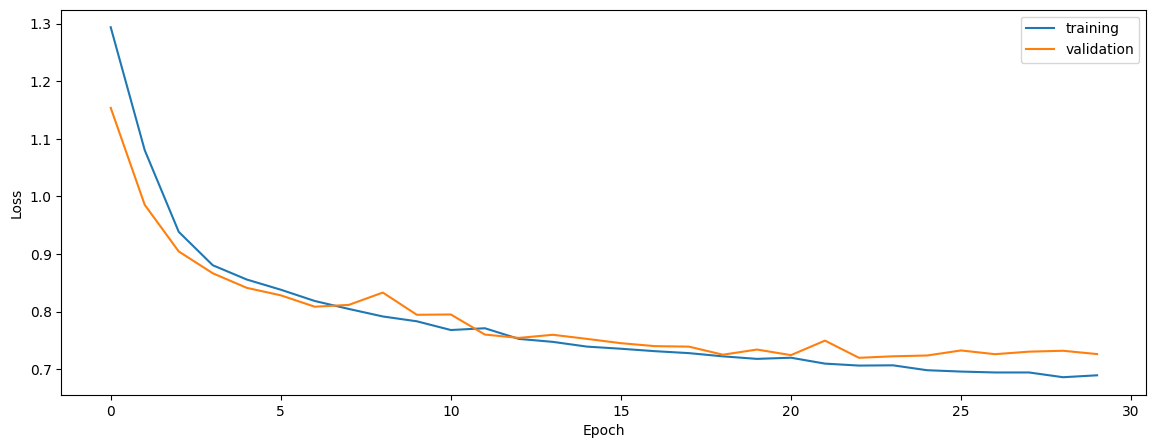

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


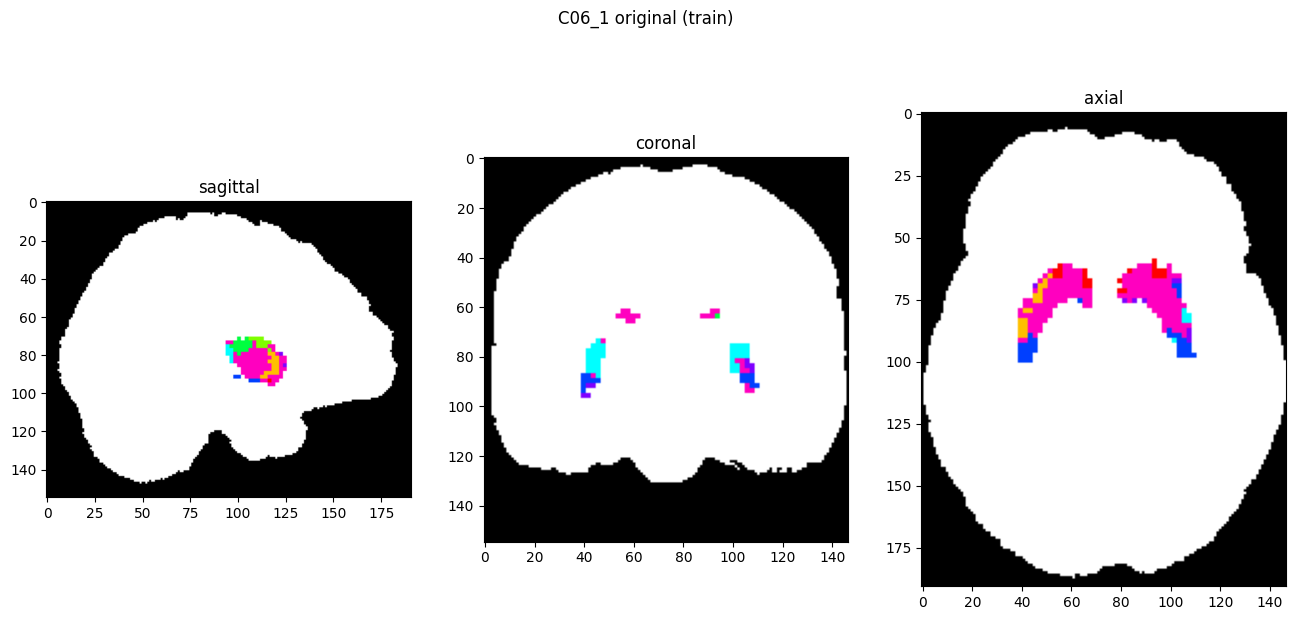

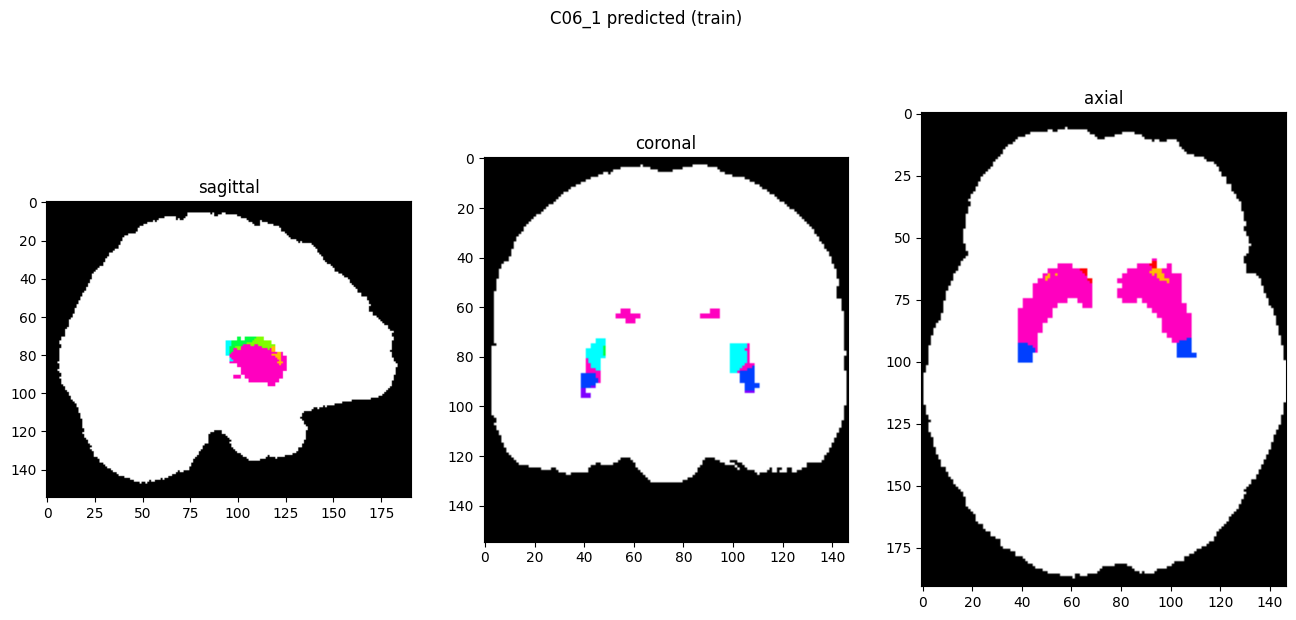

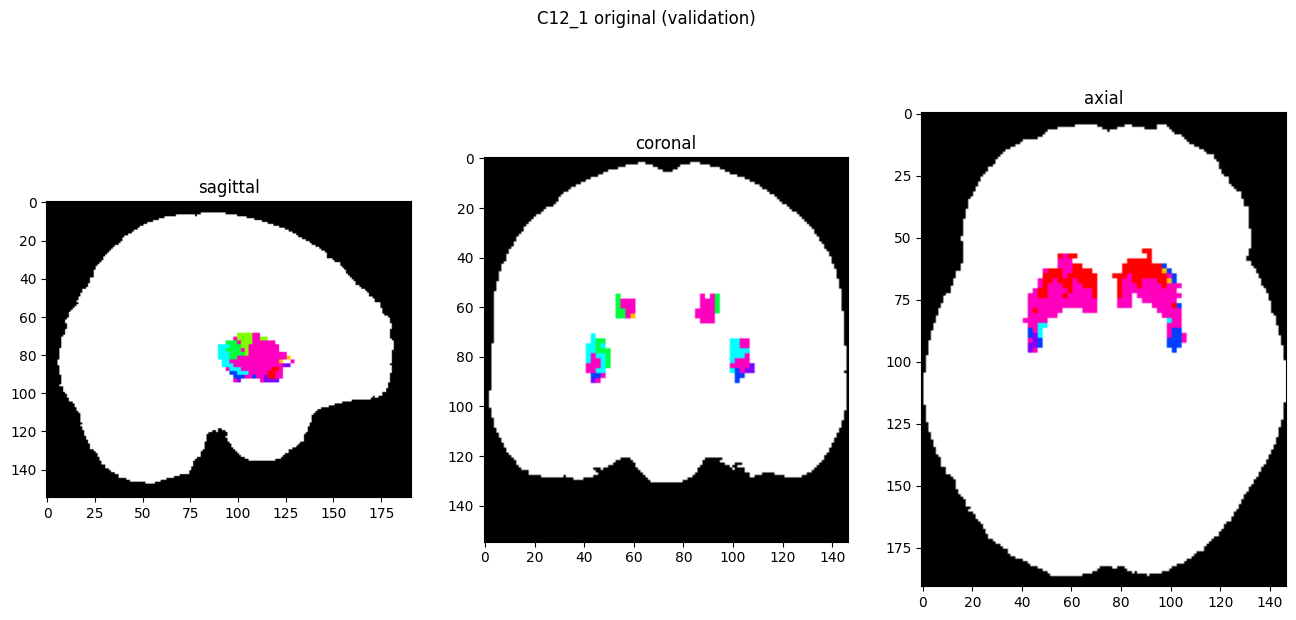

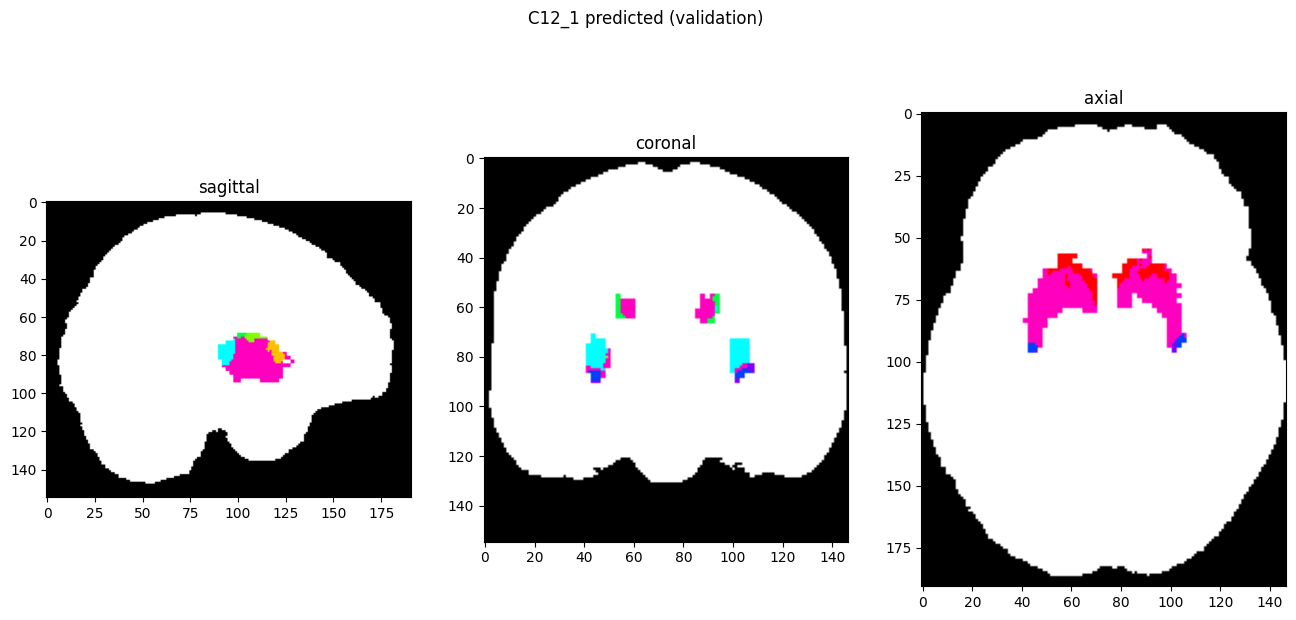

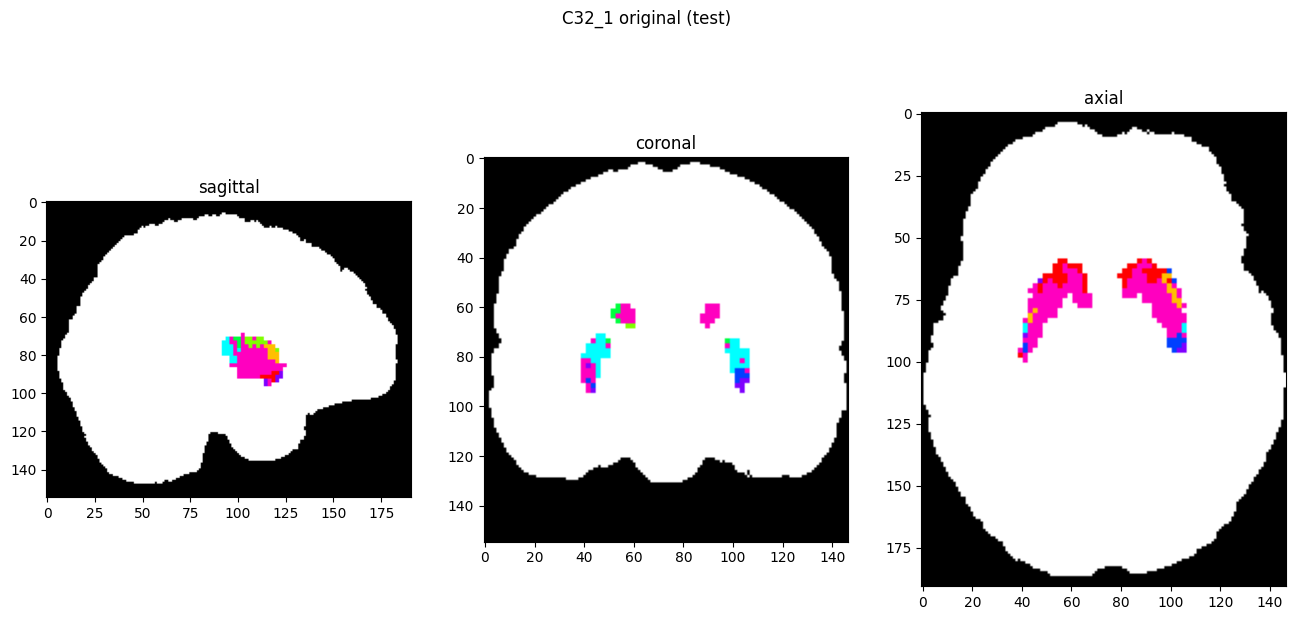

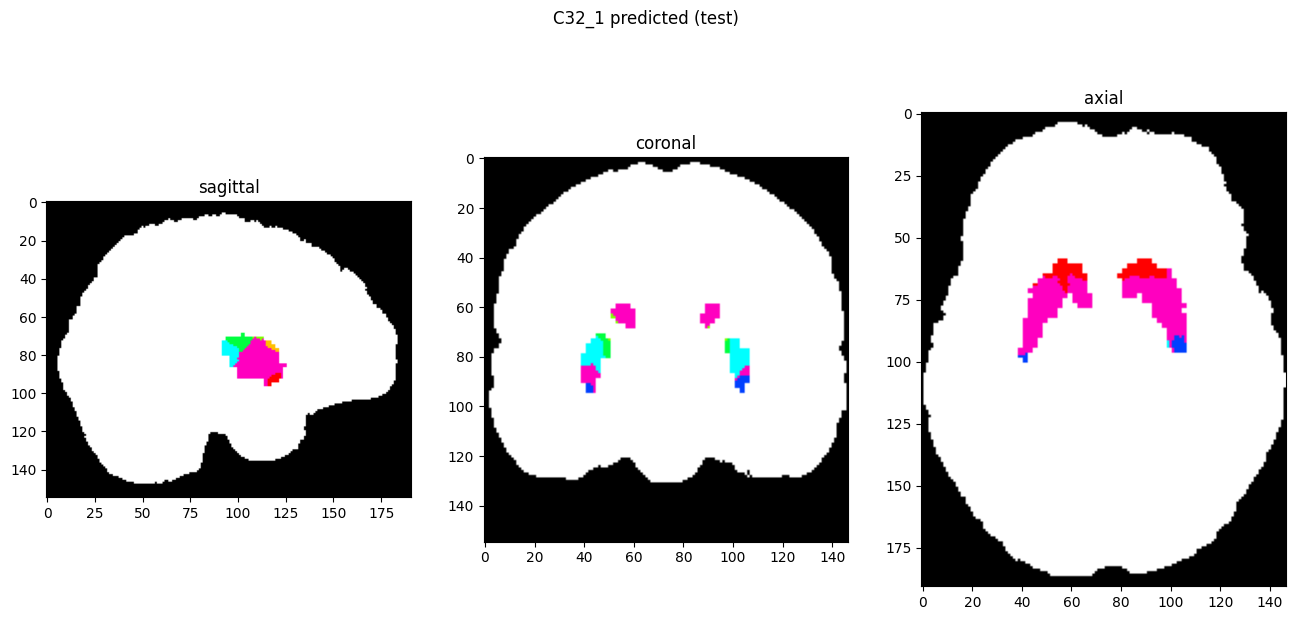

In [10]:
showResults(model, gen, threshold=0)